In [17]:
pip install pandas numpy scikit-learn nltk matplotlib seaborn torch transformers tqdm

   ---------------------------------------- 0.0/110.9 MB ? eta -:--:--
   ---------------------------------------- 0.8/110.9 MB 5.6 MB/s eta 0:00:20
    --------------------------------------- 2.4/110.9 MB 7.1 MB/s eta 0:00:16
   - -------------------------------------- 3.9/110.9 MB 7.3 MB/s eta 0:00:15
   - -------------------------------------- 5.2/110.9 MB 7.2 MB/s eta 0:00:15
   -- ------------------------------------- 7.1/110.9 MB 7.3 MB/s eta 0:00:15
   --- ------------------------------------ 8.7/110.9 MB 7.5 MB/s eta 0:00:14
   --- ------------------------------------ 10.5/110.9 MB 7.5 MB/s eta 0:00:14
   ---- ----------------------------------- 11.5/110.9 MB 7.3 MB/s eta 0:00:14
   ---- ----------------------------------- 13.4/110.9 MB 7.4 MB/s eta 0:00:14
   ----- ---------------------------------- 14.7/110.9 MB 7.2 MB/s eta 0:00:14
   ----- ---------------------------------- 16.3/110.9 MB 7.3 MB/s eta 0:00:13
   ------ --------------------------------- 17.8/110.9 MB 7.3 MB/s

In [9]:
import pandas as pd
import numpy as np
import re
import string
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [11]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC


In [13]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, 
    precision_recall_fscore_support
)

In [21]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW  
from transformers import (
    DistilBertTokenizer, 
    DistilBertForSequenceClassification,
    get_linear_schedule_with_warmup
)
from tqdm.notebook import tqdm

In [23]:
np.random.seed(42)
torch.manual_seed(42)

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔥 Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

🔥 Using device: cpu
PyTorch version: 2.9.1+cpu


In [29]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [31]:
nltk_packages = ['stopwords', 'wordnet', 'punkt', 'omw-1.4']

for package in nltk_packages:
    try:
        nltk.data.find(f'corpora/{package}')
        print(f"✅ {package} already downloaded")
    except LookupError:
        print(f"⬇️ Downloading {package}...")
        nltk.download(package, quiet=True)

print("\n✅ NLTK data ready!")

⬇️ Downloading stopwords...
⬇️ Downloading wordnet...
⬇️ Downloading punkt...
⬇️ Downloading omw-1.4...

✅ NLTK data ready!


In [37]:
filepath = 'DisasterTweets.csv'  # ← CHANGE THIS

try:
    df = pd.read_csv(filepath)
    print("Dataset loaded successfully!\n")
except FileNotFoundError:
    print("Error: File not found!")
    print("Please update the 'filepath' variable with your CSV file location")
    raise

Dataset loaded successfully!



In [39]:
print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(f"\nDataset Shape: {df.shape}")
print(f"Number of rows: {df.shape[0]:,}")
print(f"Number of columns: {df.shape[1]}")

print("\nColumn Names:")
print(df.columns.tolist())

print("\nFirst 5 rows:")
df.head()

DATASET OVERVIEW

Dataset Shape: (2559, 13)
Number of rows: 2,559
Number of columns: 13

Column Names:
['Name', 'UserName', 'Timestamp', 'Verified', 'Tweets', 'Comments', 'Retweets', 'Likes', 'Impressions', 'Tags', 'Tweet Link', 'Tweet ID', 'Disaster']

First 5 rows:


,Name,UserName,Timestamp,Verified,Tweets,Comments,Retweets,Likes,Impressions,Tags,Tweet Link,Tweet ID,Disaster
0,Drought Center,@DroughtCenter,2024-02-29T13:30:07.000Z,False,US Drought Monitor 2-29-24\n\nHappy Leap Day! ...,0,17,13,18000,"['#droughtmonitor', '#drought', '#drought2024'...",https://twitter.com/DroughtCenter/status/17631...,1.763190e+18,Drought
1,Prabhakar Goud Kurmimdla,@PrabhakarGoud_K,2024-02-27T05:20:43.000Z,False,Synonym is #Drought,0,0,1,13,['#Drought'],https://twitter.com/PrabhakarGoud_K/status/176...,1.762350e+18,Drought
2,Humanity First International,@HFI1995,2024-03-03T07:03:34.000Z,False,"Across South America in the last two months, #...",0,9,19,419,"['#floods', '#landslides', '#drought', '#wildf...",https://twitter.com/HFI1995/status/17641848294...,1.764180e+18,Floods
3,NCWQ Worldwide News And Disasters Explorer,@RTheExplorer1,2024-02-29T10:20:18.000Z,False,Wildfires Going On In Texas #wildfires #texa...,0,0,1,34,"['#wildfires', '#texasfires']",https://twitter.com/RTheExplorer1/status/17631...,1.763150e+18,Wildfire
4,BestDealsEver,@MilwaukeeHotBuy,2024-02-28T17:58:01.000Z,False,START YOUR STAND UP COMEDY CAREER FOR $11.99 ...,0,0,0,210,"['#thevoice', '#rhonj', '#taylorswift', '#mia'...",https://twitter.com/MilwaukeeHotBuy/status/176...,1.762900e+18,Hurricanes


In [51]:
print("\n" + "=" * 80)
print("DATA QUALITY CHECK")
print("=" * 80)
print("\nData Types:")
print(df.dtypes)
print("\nMissing Values:")
missing = df.isnull().sum()
if missing.sum() == 0:
    print("✅ No missing values!")
else:
    print(missing[missing > 0])

print("\nDataset Info:")
df.info()



DATA QUALITY CHECK

Data Types:
Name            object
UserName        object
Timestamp       object
Verified          bool
Tweets          object
Comments         int64
Retweets         int64
Likes           object
Impressions      int64
Tags            object
Tweet Link      object
Tweet ID       float64
Disaster        object
dtype: object

Missing Values:
Name    1
dtype: int64

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2559 entries, 0 to 2558
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         2558 non-null   object 
 1   UserName     2559 non-null   object 
 2   Timestamp    2559 non-null   object 
 3   Verified     2559 non-null   bool   
 4   Tweets       2559 non-null   object 
 5   Comments     2559 non-null   int64  
 6   Retweets     2559 non-null   int64  
 7   Likes        2559 non-null   object 
 8   Impressions  2559 non-null   int64  
 9   Tags         2559 non-nul

In [53]:
print("\n" + "=" * 80)
print("SAMPLE TWEETS FROM EACH DISASTER TYPE")
print("=" * 80)
for disaster in df['Disaster'].unique()[:5]:  # Show first 5 disaster types
    print(f"\n{'─' * 80}")
    print(f"📌 {disaster.upper()}")
    print('─' * 80)
    sample = df[df['Disaster'] == disaster]['Tweets'].iloc[0]
    print(f"{sample[:200]}..." if len(sample) > 200 else sample)


SAMPLE TWEETS FROM EACH DISASTER TYPE

────────────────────────────────────────────────────────────────────────────────
📌 DROUGHT
────────────────────────────────────────────────────────────────────────────────
US Drought Monitor 2-29-24

Happy Leap Day! For the 50 states and Puerto Rico, the US Drought Monitor shows 18.09% in moderate drought or worse, compared to 16.62% last week.#droughtmonitor #drought #...

────────────────────────────────────────────────────────────────────────────────
📌 FLOODS
────────────────────────────────────────────────────────────────────────────────
Across South America in the last two months, #floods and #landslides in Bolivia and Ecuador, and #drought and #wildfires in Chile and Colombia are ongoing signs of the #ClimateCrisis

────────────────────────────────────────────────────────────────────────────────
📌 WILDFIRE
────────────────────────────────────────────────────────────────────────────────
Wildfires  Going On In Texas  #wildfires #texasfires

─

In [73]:
print("=" * 80)
print("DISASTER TYPE DISTRIBUTION")
print("=" * 80)

disaster_counts = df['Disaster'].value_counts()
print("\nCount of tweets per disaster type:")
print(disaster_counts)

print(f"\nTotal unique disaster types: {df['Disaster'].nunique()}")



DISASTER TYPE DISTRIBUTION

Count of tweets per disaster type:
Disaster
Drought       770
Wildfire      540
Earthquake    500
Floods        436
Hurricanes    178
Tornadoes     135
Name: count, dtype: int64

Total unique disaster types: 6


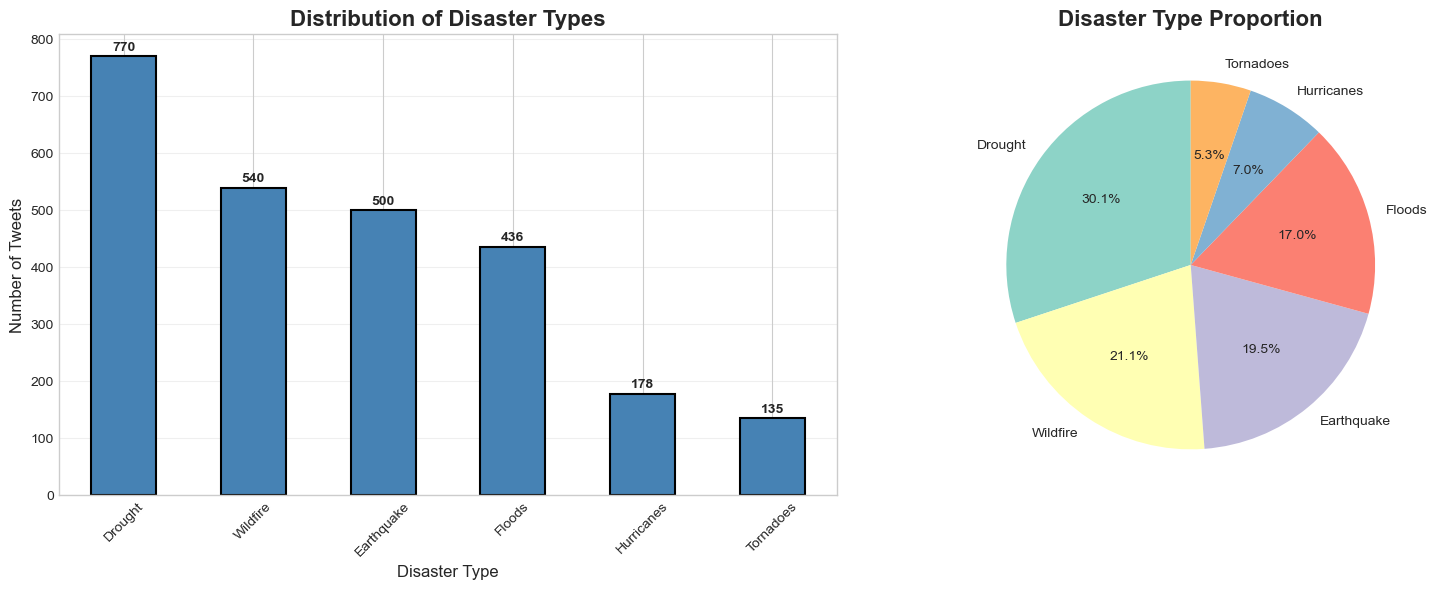


✅ Visualization saved as 'disaster_distribution.png'


In [93]:
# Visualize distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot
disaster_counts.plot(kind='bar', ax=ax1, color='steelblue', edgecolor='black', linewidth=1.5)
ax1.set_title('Distribution of Disaster Types', fontsize=16, fontweight='bold')
ax1.set_xlabel('Disaster Type', fontsize=12)
ax1.set_ylabel('Number of Tweets', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, v in enumerate(disaster_counts.values):
    ax1.text(i, v + 10, str(v), ha='center', fontweight='bold')

# Pie chart
colors = plt.cm.Set3(range(len(disaster_counts)))
ax2.pie(disaster_counts.values, labels=disaster_counts.index, autopct='%1.1f%%',
        startangle=90, colors=colors, textprops={'fontsize': 10})
ax2.set_title('Disaster Type Proportion', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.savefig('disaster_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualization saved as 'disaster_distribution.png'")


In [96]:
# Tweet length analysis
df['Tweet_Length'] = df['Tweets'].astype(str).apply(len)
df['Word_Count'] = df['Tweets'].astype(str).apply(lambda x: len(x.split()))

print("\n" + "=" * 80)
print("TWEET LENGTH STATISTICS")
print("=" * 80)

print("\nCharacter Length Statistics:")
print(df['Tweet_Length'].describe())

print("\nWord Count Statistics:")
print(df['Word_Count'].describe())



TWEET LENGTH STATISTICS

Character Length Statistics:
count    2559.000000
mean      186.926143
std        83.068439
min         8.000000
25%       115.000000
50%       192.000000
75%       256.000000
max       440.000000
Name: Tweet_Length, dtype: float64

Word Count Statistics:
count    2559.000000
mean       23.658851
std        11.261606
min         1.000000
25%        15.000000
50%        22.000000
75%        33.000000
max        56.000000
Name: Word_Count, dtype: float64


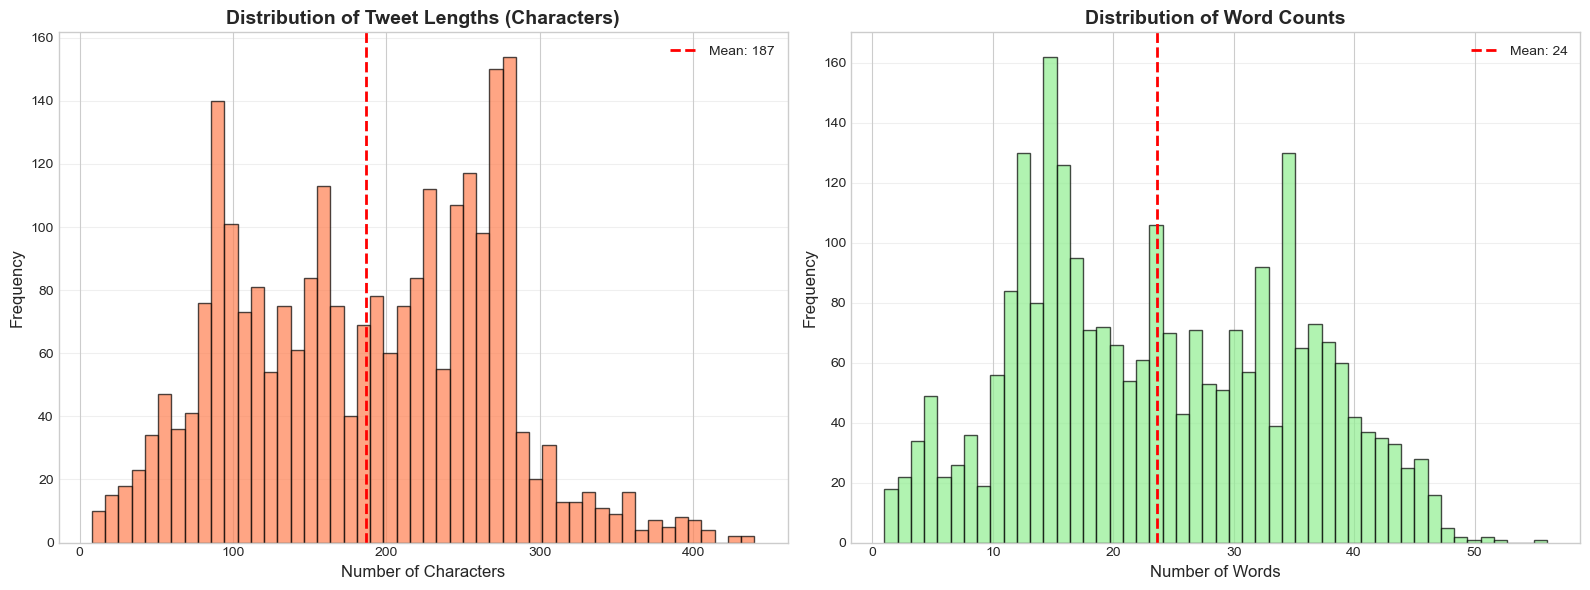


✅ Visualization saved as 'tweet_length_distribution.png'


In [98]:
# Visualize tweet lengths
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Character length distribution
ax1.hist(df['Tweet_Length'], bins=50, color='coral', edgecolor='black', alpha=0.7)
ax1.set_title('Distribution of Tweet Lengths (Characters)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Characters', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.axvline(df['Tweet_Length'].mean(), color='red', linestyle='--', 
            linewidth=2, label=f'Mean: {df["Tweet_Length"].mean():.0f}')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Word count distribution
ax2.hist(df['Word_Count'], bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
ax2.set_title('Distribution of Word Counts', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Words', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.axvline(df['Word_Count'].mean(), color='red', linestyle='--', 
            linewidth=2, label=f'Mean: {df["Word_Count"].mean():.0f}')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('tweet_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualization saved as 'tweet_length_distribution.png'")


### Text Preprocessing for Classical ML Models

In [107]:
import nltk

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ARCHANA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ARCHANA\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ARCHANA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ARCHANA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ARCHANA\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [109]:
class TextPreprocessor:
    """
    Comprehensive text preprocessing for classical ML models
    """
    
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        # Keep disaster-related words
        disaster_words = {'fire', 'flood', 'drought', 'earthquake', 'hurricane', 
                         'wildfire', 'disaster', 'emergency', 'evacuation'}
        self.stop_words = self.stop_words - disaster_words
        
    def clean_text(self, text):
        """Clean and normalize text"""
        if pd.isna(text):
            return ""
        
        text = str(text)
        
        # Convert to lowercase
        text = text.lower()
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        
        # Remove @mentions
        text = re.sub(r'@\w+', '', text)
        
        # Remove hashtag symbol but keep the word
        text = re.sub(r'#(\w+)', r'\1', text)
        
        # Remove emojis and special characters
        text = text.encode('ascii', 'ignore').decode('ascii')
        
        # Remove numbers
        text = re.sub(r'\d+', '', text)
        
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        
        # Remove extra whitespace
        text = ' '.join(text.split())
        
        return text
    
    def tokenize_and_lemmatize(self, text):
        """Tokenize, remove stopwords, and lemmatize"""
        # Tokenize
        tokens = word_tokenize(text)
        
        # Remove stopwords and lemmatize
        tokens = [
            self.lemmatizer.lemmatize(token)
            for token in tokens
            if token not in self.stop_words and len(token) > 2
        ]
        
        return ' '.join(tokens)
    
    def preprocess(self, text):
        """Complete preprocessing pipeline"""
        text = self.clean_text(text)
        text = self.tokenize_and_lemmatize(text)
        return text

# %%
# Apply preprocessing
print("=" * 80)
print("PREPROCESSING TWEETS")
print("=" * 80)

preprocessor = TextPreprocessor()

print("\n📝 Original Tweet Example:")
print("-" * 80)
original_tweet = df['Tweets'].iloc[0]
print(f"{original_tweet}\n")

print("🔄 Processing all tweets...")
df['Processed_Tweets'] = df['Tweets'].apply(preprocessor.preprocess)

print("\n✨ Processed Tweet Example:")
print("-" * 80)
print(f"{df['Processed_Tweets'].iloc[0]}\n")

# Remove empty tweets after preprocessing
initial_count = len(df)
df = df[df['Processed_Tweets'].str.strip() != '']
final_count = len(df)

print(f"✅ Preprocessing complete!")
print(f"   Original tweets: {initial_count:,}")
print(f"   After cleaning: {final_count:,}")
print(f"   Removed: {initial_count - final_count} empty tweets")



PREPROCESSING TWEETS

📝 Original Tweet Example:
--------------------------------------------------------------------------------
US Drought Monitor 2-29-24

Happy Leap Day! For the 50 states and Puerto Rico, the US Drought Monitor shows 18.09% in moderate drought or worse, compared to 16.62% last week.#droughtmonitor #drought #drought2024 #climate #science #data #maps #UnitedStates #USA #US

🔄 Processing all tweets...

✨ Processed Tweet Example:
--------------------------------------------------------------------------------
drought monitor happy leap day state puerto rico drought monitor show moderate drought worse compared last weekdroughtmonitor drought drought climate science data map unitedstates usa

✅ Preprocessing complete!
   Original tweets: 2,559
   After cleaning: 2,558
   Removed: 1 empty tweets


#### Label Encoding

In [112]:
unique_disasters = sorted(df['Disaster'].unique())
label_mapping = {disaster: idx for idx, disaster in enumerate(unique_disasters)}
reverse_mapping = {v: k for k, v in label_mapping.items()}

print("\n📊 Label Mapping:")
print("-" * 80)
for disaster, label in label_mapping.items():
    count = (df['Disaster'] == disaster).sum()
    print(f"{label} → {disaster:15s} ({count:,} tweets)")


📊 Label Mapping:
--------------------------------------------------------------------------------
0 → Drought         (769 tweets)
1 → Earthquake      (500 tweets)
2 → Floods          (436 tweets)
3 → Hurricanes      (178 tweets)
4 → Tornadoes       (135 tweets)
5 → Wildfire        (540 tweets)


In [116]:
df['Label'] = df['Disaster'].map(label_mapping)

print(f"\n✅ Labels encoded successfully!")
print(f"   Number of classes: {len(label_mapping)}")



✅ Labels encoded successfully!
   Number of classes: 6


#### Train-test Split

In [121]:
print("=" * 80)
print("SPLITTING DATA")
print("=" * 80)

# Prepare features and labels
X = df['Processed_Tweets'].values
y = df['Label'].values

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"\n✅ Data split complete!")
print(f"   Training samples: {len(X_train):,} ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Test samples: {len(X_test):,} ({len(X_test)/len(X)*100:.1f}%)")


SPLITTING DATA

✅ Data split complete!
   Training samples: 2,046 (80.0%)
   Test samples: 512 (20.0%)


In [123]:
print("\n📊 Class Distribution in Training Set:")
train_dist = pd.Series(y_train).value_counts().sort_index()
for idx, count in train_dist.items():
    print(f"   {reverse_mapping[idx]:15s}: {count:4d} samples")

print("\n📊 Class Distribution in Test Set:")
test_dist = pd.Series(y_test).value_counts().sort_index()
for idx, count in test_dist.items():
    print(f"   {reverse_mapping[idx]:15s}: {count:4d} samples")


📊 Class Distribution in Training Set:
   Drought        :  615 samples
   Earthquake     :  400 samples
   Floods         :  349 samples
   Hurricanes     :  142 samples
   Tornadoes      :  108 samples
   Wildfire       :  432 samples

📊 Class Distribution in Test Set:
   Drought        :  154 samples
   Earthquake     :  100 samples
   Floods         :   87 samples
   Hurricanes     :   36 samples
   Tornadoes      :   27 samples
   Wildfire       :  108 samples


#### Feature Extraction

In [126]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,      # Top 5000 features
    ngram_range=(1, 2),     # Unigrams and bigrams
    min_df=2,               # Minimum document frequency
    max_df=0.8,             # Maximum document frequency
    sublinear_tf=True       # Apply sublinear tf scaling
)

print("\n🔄 Fitting TF-IDF vectorizer on training data...")
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"\n✅ TF-IDF vectorization complete!")
print(f"   Training shape: {X_train_tfidf.shape}")
print(f"   Test shape: {X_test_tfidf.shape}")
print(f"   Vocabulary size: {len(tfidf_vectorizer.vocabulary_):,}")
print(f"   Sparsity: {(1.0 - X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1])) * 100:.2f}%")

# Show top features
feature_names = tfidf_vectorizer.get_feature_names_out()
print("\n📝 Sample TF-IDF Features (first 20):")
print(feature_names[:20])



🔄 Fitting TF-IDF vectorizer on training data...

✅ TF-IDF vectorization complete!
   Training shape: (2046, 5000)
   Test shape: (512, 5000)
   Vocabulary size: 5,000
   Sparsity: 99.68%

📝 Sample TF-IDF Features (first 20):
['abbott' 'abc' 'ability' 'able' 'able make' 'ableg' 'ableg abpoli'
 'abpoli' 'abpoli climatechange' 'abpoli drought' 'abstraction'
 'abstraction agreement' 'accelerated' 'accelerated learning' 'access'
 'access twothirds' 'accidentally' 'accidentally confirms' 'according'
 'according weekly']
